Nessa versão das modelagens, será incluído um máximo de diferenças, para evitar valores negativos para populações e probabilidades.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

In [2]:
#%display typeset

In [3]:
def model(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, T_linha - T_curr)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M * l_curr
    dImdt = b3_curr * E_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

Utilizando primeiramente os parâmetros para alcançar o equilíbrio de mosquitos:

In [4]:
T_linha = 27.4
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=317.925
B=15
C=-48.78

b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1825 
R_L = 312
N = 8558
M = 300000 
E_M0 = 50000
I_H0 = 1000 
I_M0 = 2500
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

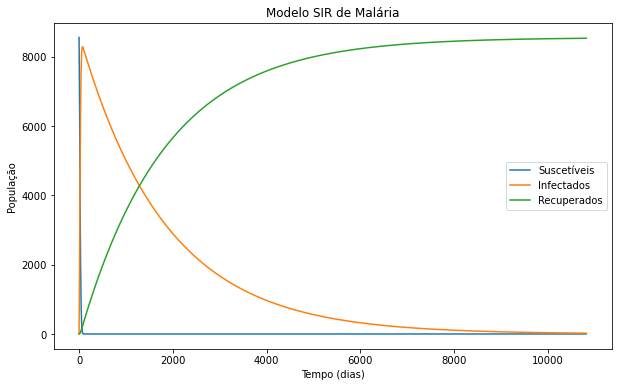

In [5]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 317.925, 15, -48.78, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

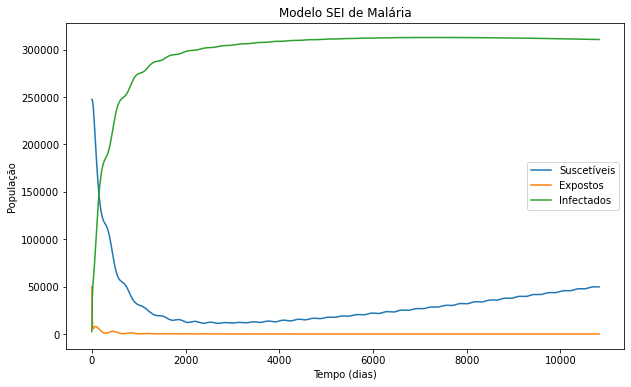

In [6]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

In [7]:
S_M[-1]+E_M[-1]+I_M[-1]

360247.7012191494

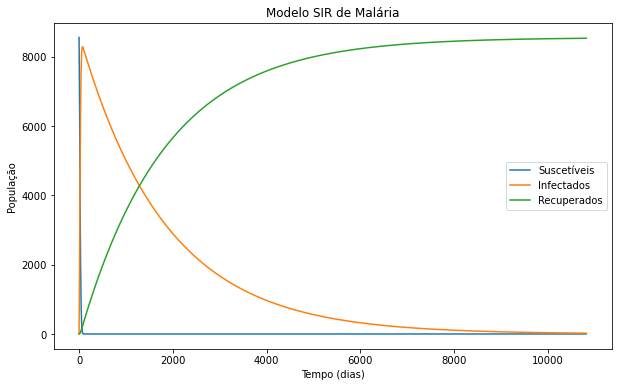

In [8]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

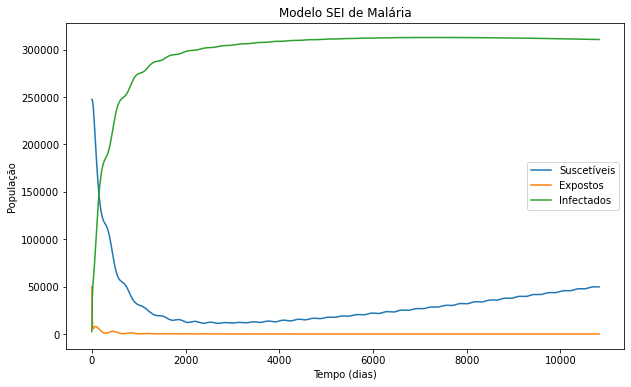

In [9]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

In [10]:
min(E_M)

1.177980802192352

In [11]:
S_M[-1]

49668.12148810114

In [12]:
E_M[-1]

5.66928078056055

In [13]:
I_M[-1]

310573.9104502677

Usando $T' = 27.4, \ A=317.925, \ B=15, \ C=-48.78$ e $R_L = 312$, é possível ver que a população de humanos, inicialmente suscetível, se torna rapidamente quase que totalmente infectada, mas logo essa tendência começa a abaixar, e a população se torna totalmente recuperada ao longo do tempo, mais especificamente por volta de $t=10000$, toda a população humana estará recuperada da malária. A população de mosquitos, por sua vez, entra em equilíbrio com a população quase que totalmente infectada, como pode ser visto acima. Curiosamente, é possível notar que ao final do período, a população de mosquitos suscetíveis volta a aumentar.

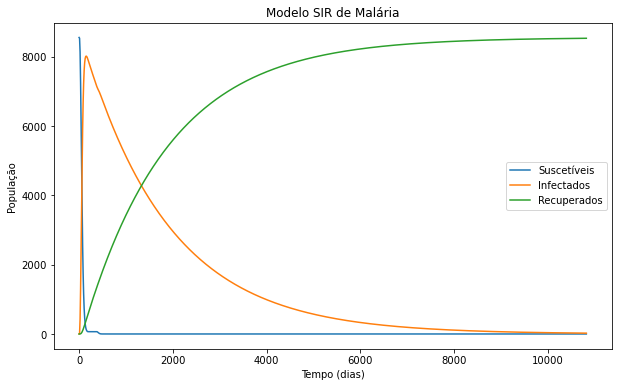

In [14]:
args = (26.4, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 317.925, 15, -48.78, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Diminuindo $T'$ em apenas um grau, pode-se ver que o formato do gráfico é o mesmo, a única diferença é que a população leva mais tempo para atingir o pico de infectados inicialmente.

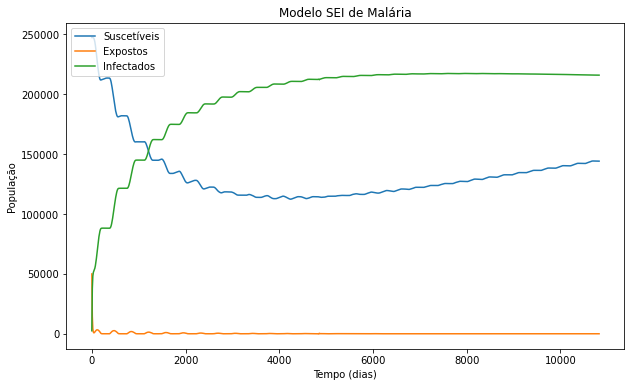

In [15]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

Observando a evolução da população de mosquitos, por outro lado, o comportamento percebido é bem diferente do resultado original com $T'=27.4$.

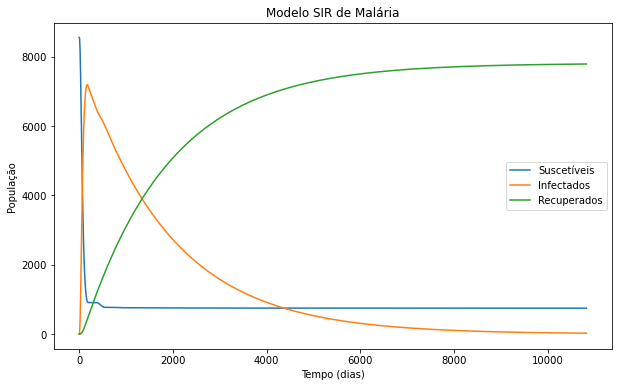

In [16]:
args = (26.4, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -1.5, 44.31, -1.4, b2, tau_H, DD, Tmin, gamma, 400,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [17]:
min(I_H)

0.0

Passando um $T'$ baixo, é possível notar que, enquanto a população de suscetíveis se estabiliza acima de 0, a população de infectados se torna 0.

In [18]:
# Usando B=40.31, ocorreu um math domain error. Usando B=35.31, o código entrou em loop.

# args = (26.4, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, -1.5, 40.31, -1.4, b2, tau_H, DD, Tmin, gamma, 400,
#                    N, M, E_M0, I_H0, I_M0)

# t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
# sol = solve_ivp(model, [0, 10825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_H, label='Suscetíveis')
# plt.plot(times, I_H, label='Infectados')
# plt.plot(times, R_H, label='Recuperados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

In [19]:
# Usando B=30.31, o código entrou em loop.
# args = (26.4, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, -1.5, 30.31, -1.4, b2, tau_H, DD, Tmin, gamma, 400,
#                    N, M, E_M0, I_H0, I_M0)

# t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
# sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_H, label='Suscetíveis')
# plt.plot(times, I_H, label='Infectados')
# plt.plot(times, R_H, label='Recuperados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

# Diminuindo $B$ de 44.31 para 30.31, é possível notar que, enquanto antes a população de humanos 
# suscetíveis se estabilizava proximamente a 1000, agora essa população tende a 0,
# e todos os humanos ficam recuperados ao final do período.

In [20]:
# Usando B=10.31, para T1 = 26.4, o código entrou em loop.

# args = (26.4, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, -1.5, 10.31 , -1.4, b2, tau_H, DD, Tmin, gamma, 400,
#                    N, M, E_M0, I_H0, I_M0)

# t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
# sol = solve_ivp(model, [0, 10825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_H, label='Suscetíveis')
# plt.plot(times, I_H, label='Infectados')
# plt.plot(times, R_H, label='Recuperados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

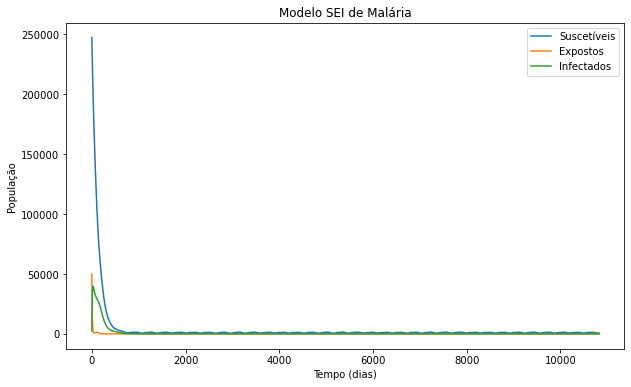

In [21]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

Analisando o efeito de $T'$ mais alto

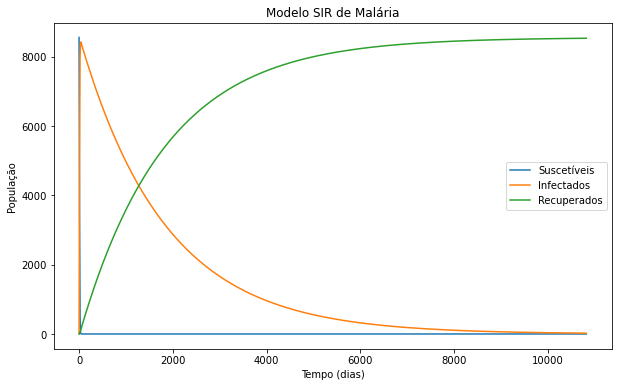

In [22]:
args = (30, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 317.925, 15, -48.78, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

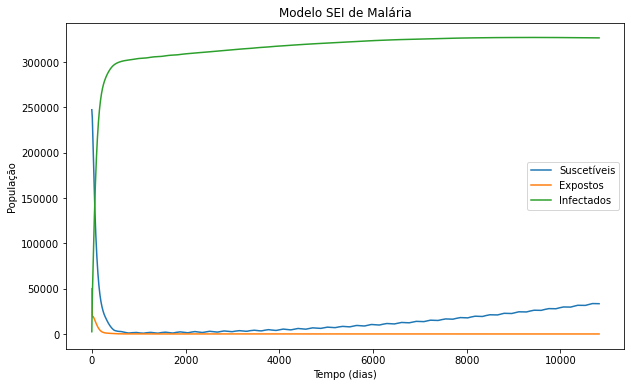

In [23]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

Aumentando $T'$ e utilizando os valores originais de $A, \ B$ e $C$, é possível notar como, para a população humana, o número de infectados aumenta de forma ainda mais rápida, consequentemente decresce rapidamente também. Já para a população de mosquitos, pode ser notado que a evolução das populações fica menos oscilante.

Analisando os valores da taxa de picadas:

In [24]:
def model(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, T_linha - T_curr)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M * l_curr
    dImdt = b3_curr * E_M * l_curr - mu_curr * I_M
    
    print(a_curr)
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [25]:
args = (27.4, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 317.925, 15, -48.78, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

0.025218306088151666
0.025218306410835112
0.02521830778547075
0.025218308634130146
0.025218309907119433
0.025218315176515457
0.025218316844261266
0.025218314155233793
0.025218316016868123
0.025218327103935775
0.025218325449149488
0.025218333746720778
0.025218338356482798
0.025218338356482798
0.02521830931498446
0.025218312541817348
0.025218331185741964
0.025218355329676742
0.02521836381627449
0.025218376546171945
0.0252184292401646
0.025218445917637083
0.025218419027341236
0.02521843764369942
0.025218548514503367
0.025218531966616848
0.025218614942466282
0.02521866104018052
0.02521866104018052
0.025218370624820935
0.025218402893165986
0.025218589332631228
0.025218830772578495
0.025218915638850436
0.025219042938349694
0.025219569881495322
0.02521973665759021
0.02521946775250469
0.0252196539175118
0.02522076263840499
0.02522059715714741
0.02522142692931476
0.025221887915861302
0.025221887915861302
0.025218983724582165
0.025219306409687933
0.025221170826297778
0.025223585285592414
0.02522

0.04084899659399579
0.040506261103008694
0.03833456694111304
0.037180071290310916
0.0370590438878569
0.036876363580368346
0.03610617436390168
0.03585791482451595
0.03625715919637195
0.035981341135919935
0.03428769311282183
0.034545629799084376
0.033236277467815614
0.03249315425307798
0.03249315425307798
0.036961506650389435
0.036494031373612526
0.0336445210202951
0.03215225279719734
0.03198110928546393
0.03172357422253827
0.030648221062897885
0.030305179836290982
0.030857703257369393
0.03047551025393612
0.028175971948818393
0.028520915711335294
0.026789683359581998
0.02582927891888081
0.02582927891888081
0.0318434870536257
0.031187650754522383
0.027324159042398665
0.025423125474365336
0.025220412954207506
0.024916872046301643
0.023668923254206803
0.02327747538964212
0.02390955269756083
0.023471437112646334
0.020921120416638544
0.021294160872984597
0.019456991591480285
0.018476685355423586
0.018476685355423586
0.025057981901386757
0.024290991387037587
0.020014734948258013
0.017900569802

0.02544710271048973
0.025287517048951713
0.02504845453748599
0.024063787534705474
0.023754113982211538
0.024253930446248906
0.023907614704407793
0.02187700802158089
0.0221760249973917
0.02069423044675822
0.019892138923340925
0.019892138923340925
0.02515960591850126
0.024555040618746964
0.021146697815897154
0.01946391020589308
0.019251818096565263
0.018936310110852325
0.017666355824979527
0.01727742723611932
0.017907722689749148
0.017469558747120396
0.015041598865527259
0.015382693792637748
0.013755582832305092
0.012946565470616907
0.012946565470616907
0.019082670928916814
0.01829381125931849
0.01423512344213475
0.01256058128164914
0.012374929133609163
0.012105799361950059
0.011115069967794615
0.010844250875015041
0.011291216687380697
0.010975982790560442
0.009654947492784158
0.009789923900423386
0.00933926197100138
0.009335141604157096
0.009335141604157096
0.012229580335756914
0.011585201139152465
0.009417819653366497
0.009395277128511542
0.009440330079741377
0.009526572670426647
0.010

In [26]:
def model(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, T_linha - T_curr)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M * l_curr
    dImdt = b3_curr * E_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

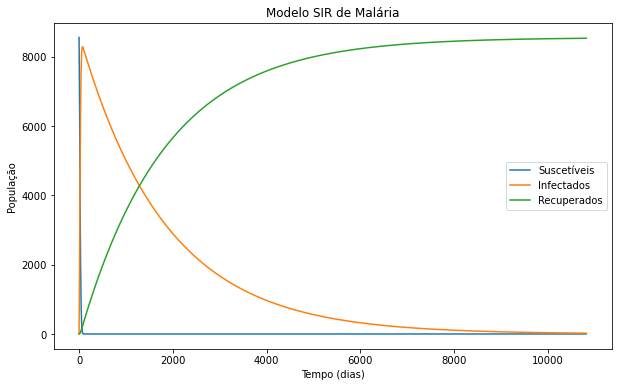

In [27]:
args = (27.4, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 317.925, 15, -48.78, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [28]:
max(I_H)

8291.08810888373

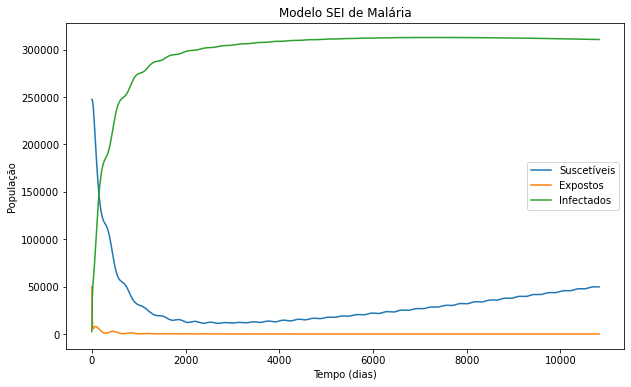

In [29]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

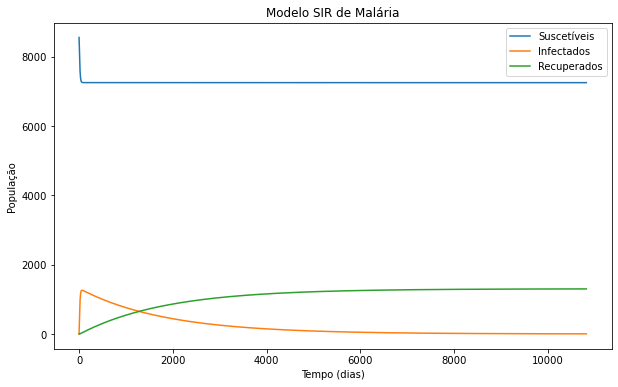

In [30]:
# A, B e C do artigo
args = (27.4, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -0.03 , 1.31 , -4.4, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

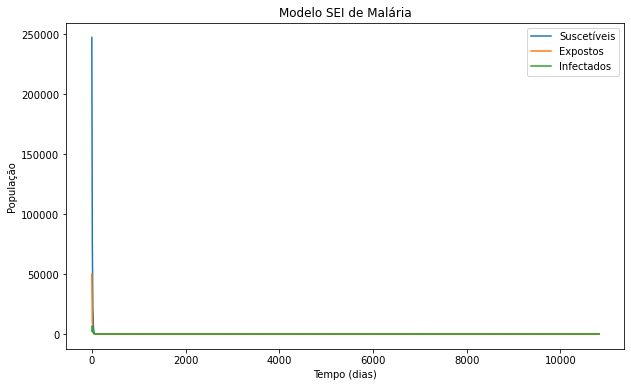

In [31]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

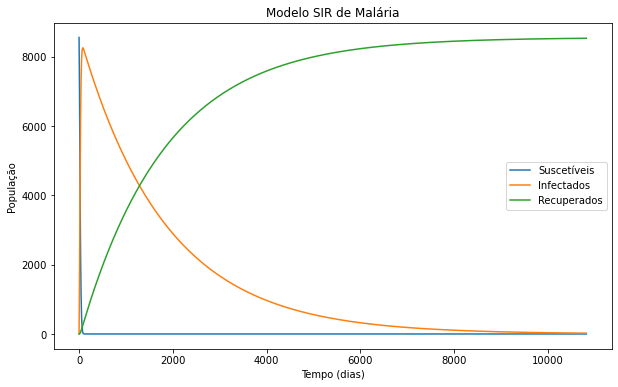

In [32]:
args = (27.4, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -1.5, 50.31 , -1.4, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [33]:
max(I_H)

8257.729553086725

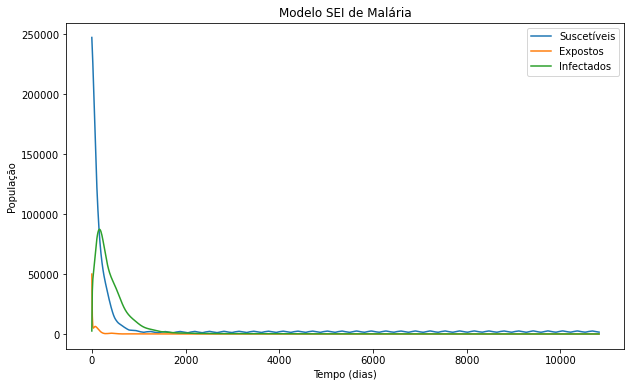

In [34]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

Diminuindo $A, \ B$ e $C$, como esperado, fez com que a população de mosquitos tendesse à extinção, mas esse efeito também acabou diminuindo o número máximo de humanos infectados ao longo do período. 

$dShdt = -a_{curr} . b2 . (I_M / N) . S_H \\
dIhdt = a_{curr} . b2 . (I_M / N) . S_H - \gamma . I_H \\
dRhdt = \gamma . I_H \\
\\\\
dSmdt = b_{curr} - a_{curr} . b1 . (I_H / N) . S_M - \mu_{curr} . S_M \\
dEmdt = a_{curr} . b1 . (I_H / N) . S_M - \mu_{curr} . E_M - b3_{curr} . E_M . l_{curr} \\
dImdt = b3_{curr} . E_M . l_{curr} - \mu_{curr} . I_M$

In [35]:
%display typeset

#### Calculando a Jacobiana do SIR:

In [36]:
var('S_H I_H a b2 I_M N gamma')

(S_H, I_H, a, b2, I_M, N, gamma)

In [37]:
dShdt = -a * b2 * (I_M / N) * S_H
dIhdt = a * b2 * (I_M / N) * S_H - gamma * I_H
dRhdt = gamma * I_H

In [38]:
solve([dShdt,dIhdt],[S_H,I_H])

[[S_H == 0, I_H == 0]]

In [39]:
jack_sir=jacobian([dShdt,dIhdt],[S_H,I_H])
jack_sir

[-I_M*a*b2/N           0]
[ I_M*a*b2/N      -gamma]

In [40]:
cp_sir = jack_sir.characteristic_polynomial()
cp_sir

x^2 + (I_M*a*b2/N + gamma)*x + I_M*a*b2*gamma/N

In [41]:
jack_sir.eigenvalues()

[-I_M*a*b2/N, -gamma]

#### Calculando a Jacobiana do SEI:

In [42]:
var('S_M E_M I_M b a b1 I_H N mu b3 l')

(S_M, E_M, I_M, b, a, b1, I_H, N, mu, b3, l)

In [43]:
dSmdt = b - a * b1 * (I_H / N) * S_M - mu * S_M
dEmdt = a * b1 * (I_H / N) * S_M - mu * E_M - b3 * E_M * l
dImdt = b3 * E_M * l - mu * I_M

In [44]:
solve([dSmdt,dEmdt,dIhdt],[S_M,E_M,I_M])

[[S_M == N*b/(I_H*a*b1 + N*mu), E_M == I_H*a*b*b1/(I_H*a*b1*b3*l + N*mu^2 + (I_H*a*b1 + N*b3*l)*mu), I_M == I_H*N*gamma/(S_H*a*b2)]]

In [45]:
jack_sei=jacobian([dSmdt,dEmdt,dIhdt],[S_M,E_M,I_M])
jack_sei

[-I_H*a*b1/N - mu                0                0]
[      I_H*a*b1/N       -b3*l - mu                0]
[               0                0       S_H*a*b2/N]

In [46]:
cp_sei = jack_sei.characteristic_polynomial()
cp_sei

x^3 + (I_H*a*b1/N - S_H*a*b2/N + b3*l + 2*mu)*x^2 + (-I_H*S_H*a^2*b1*b2/N^2 + I_H*a*b1*b3*l/N - S_H*a*b2*b3*l/N + I_H*a*b1*mu/N - 2*S_H*a*b2*mu/N + b3*l*mu + mu^2)*x - I_H*S_H*a^2*b1*b2*b3*l/N^2 - I_H*S_H*a^2*b1*b2*mu/N^2 - S_H*a*b2*b3*l*mu/N - S_H*a*b2*mu^2/N

In [47]:
jack_sei.eigenvalues()

[-(I_H*a*b1 + N*mu)/N, S_H*a*b2/N, -b3*l - mu]